<div >
<img src = "../banner.jpg" />
</div>

<a target="_blank" href="https://colab.research.google.com/github/ignaciomsarmiento/BDML_202402/blob/main/Lecture09/Notebook_arboles_bosques.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>


# CARTs, Bagging and Random Forests

## Predicting House Prices

Our objective today is to construct a model to predict house prices. From Rosen's landmark paper "Hedonic Prices and Implicit Markets: Product Differentiation in Pure Competition" (1974), we know that a vector of its characteristics describes a differentiated good.

In the case of a house, these characteristics may include structural attributes (e.g., number of bedrooms), neighborhood public services (e.g., local school quality), and local amenities (e.g., crime, air quality, etc). Thus, we can write the market price of the house as:

$$
Price=f(structural\,attributes,amenities,...)
$$


However, Rosen's theory doesn't tell us much about the functional form of $f$. 

## CARTS: Example

Let's load the packages:

In [ ]:
# install.packages("pacman") #run this line if you use Google Colab

In [1]:
#packages
require("pacman")
p_load("tidyverse","ggplot2")

Loading required package: pacman



 And the toy data set:

In [2]:
db<-read.csv('https://raw.githubusercontent.com/ignaciomsarmiento/datasets/main/toy_houses.csv')

In [3]:
head(db)

,price,habitaciones,DCBD
,<dbl>,<int>,<dbl>
1,162753.09,3,1.190307
2,73131.30,0,1.910839
3,162757.45,2,1.227716
4,73127.75,1,1.824990
5,73128.71,0,1.915576
6,98715.60,3,1.505208


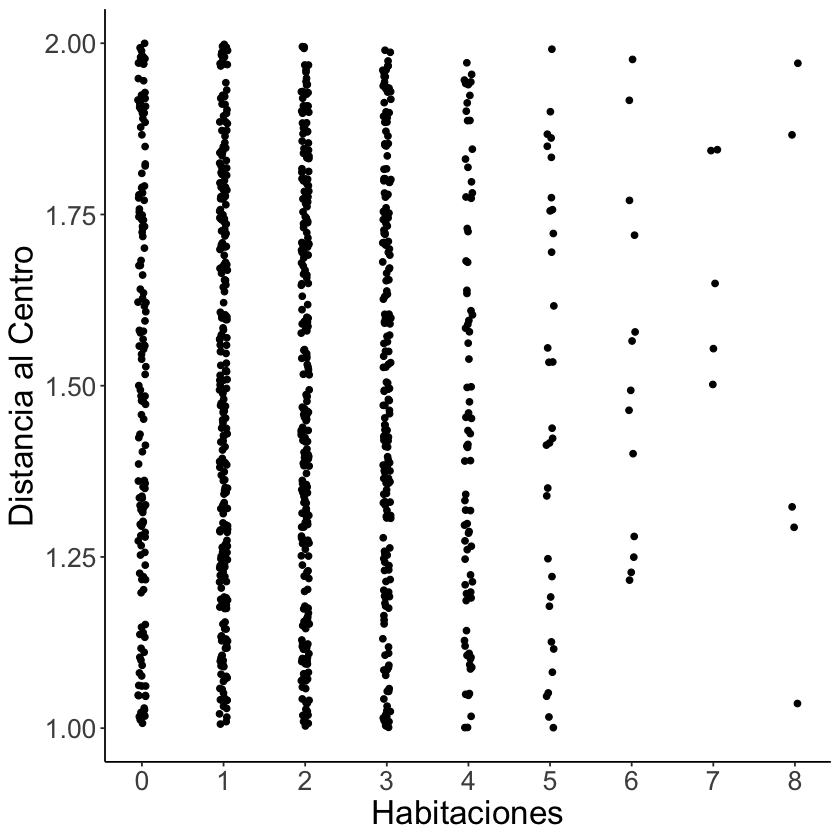

In [4]:
ggplot(db) +
  geom_point(aes(x=habitaciones,y=DCBD),position=position_jitter(width = .05)) +
  scale_x_continuous(breaks=seq(0,8,1)) +
  theme_classic() +
  xlab("Habitaciones") +
  ylab("Distancia al Centro") +
  theme(legend.position =  "none",
      text=element_text(size=20))

### Algorithm


-  Datos: $y_{n\times 1}$  y $X_{n\times k}$ 

-  Definiciones

      -  *j* es la variable que parte el espacio 
      - *s* es el punto de partición


-  Definimos los siguientes semiplanos

\begin{align}
R_1(j,s)=\{X|X_j\leq s\} \,\,\, \& \,\,\, R_2(j,s)=\{X|X_j > s\}
\end{align}

-  *El problema*: buscar la variable de partición $X_j$ y el punto $s$ de forma tal que 


\begin{align}
\underset{j,s}{min} \left[ \underset{y_{R_1}}{min}\sum_{x_i\in R_1(j,s)}(y-\gamma_{R_1})^2+ \underset{y_{R_2}}{min}\sum_{x_i\in R_2(j,s)}(y-\gamma_{R_2})^2\right]
\end{align}



#### Algorithm by hand ("artesanal")

1. Iniciemos por DBCD

In [5]:
MSE_dbcd<-NA

j<-1
for(i in seq(1,2,0.25)){
    #Region 1
  R1<- db %>% filter(DCBD<=i)
  R1<- R1 %>% mutate(c1=mean(price))
  MSEr1<- ifelse(is.na(mean((R1$price-R1$c1)^2)),0,mean((R1$price-R1$c1)^2))
    #Region 2
  R2<- db %>% filter(DCBD>i)
  R2<- R2 %>% mutate(c2=mean(price))
  MSEr2<- ifelse(is.na(mean((R2$price-R2$c2)^2)),0,mean((R2$price-R2$c2)^2))
  
  MSE_dbcd[j]<-MSEr1+MSEr2
  j<-j+1
}

MSE_dbcd

[1] 1716336929 1619184821  144556602 1612314034 1716336929

2. Luego por Habitaciones

In [6]:
MSE_hab<-NA

for(i in 0:8){
  R1<- db %>% filter(habitaciones<=i)
  R1<- R1 %>% mutate(c1=mean(price))
  MSEr1<- ifelse(is.na(mean((R1$price-R1$c1)^2)),0,mean((R1$price-R1$c1)^2))
  R2<- db %>% filter(habitaciones>i)
  R2<- R2 %>% mutate(c2=mean(price))
  MSEr2<- ifelse(is.na(mean((R2$price-R2$c2)^2)),0,mean((R2$price-R2$c2)^2))
  
  MSE_hab[i+1]<-MSEr1+MSEr2
  
}
MSE_hab

[1] 3655836376 3478068100 3029642859 2817877745 2778785039 2740560656 2585869900
[8] 2703378640 1716336929

**Mínimo?**

In [7]:
MSE<-c(MSE_dbcd,MSE_hab)
MSE[which.min(MSE)]
MSE

[1] 144556602

[1] 1716336929 1619184821  144556602 1612314034 1716336929 3655836376
 [7] 3478068100 3029642859 2817877745 2778785039 2740560656 2585869900
[13] 2703378640 1716336929

In [9]:
R1<- db %>% filter(DCBD<=1.5)
R2<-db %>% filter(DCBD<=1.5)

#### Algorithm in R

There are multiple packages, we are going to use `rpart`

In [10]:
p_load("rpart")

In [11]:
mytree<-rpart(price~DCBD+habitaciones,data=db)

In [12]:
mytree

n= 1000 

node), split, n, deviance, yval
      * denotes terminal node

1) root 1000 1.716337e+12 123534.30  
  2) DCBD>=1.499274 483 6.982083e+10  81553.15  
    4) habitaciones< 2.5 324 3.060291e+03  73130.58 *
    5) habitaciones>=2.5 159 1.696944e+03  98716.14 *
  3) DCBD< 1.499274 517 4.730729e+03 162754.70 *

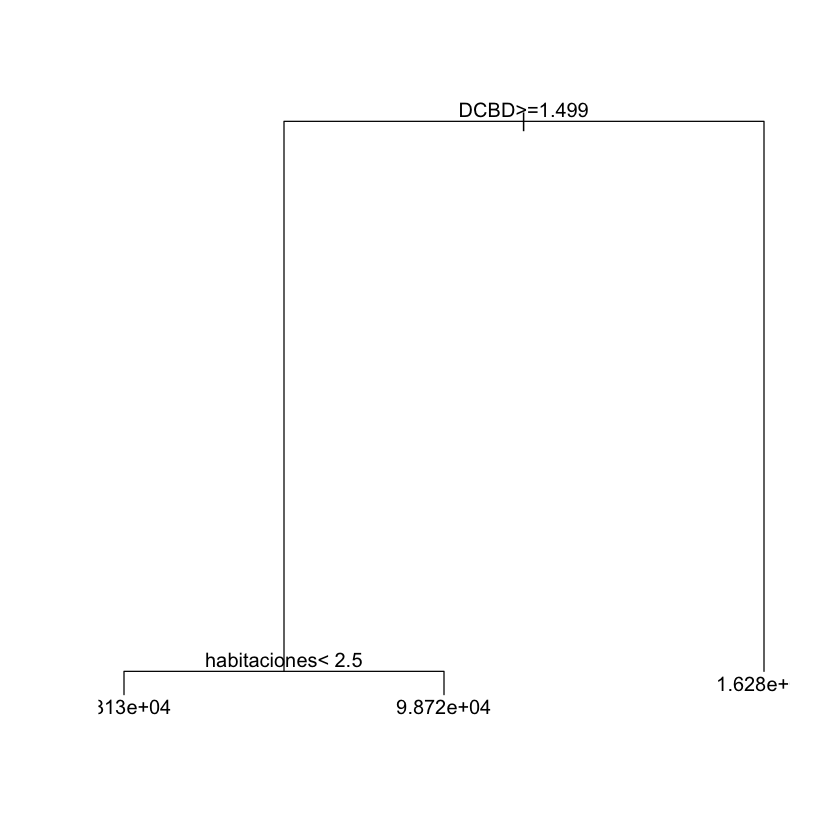

In [13]:
plot(mytree)
text(mytree)

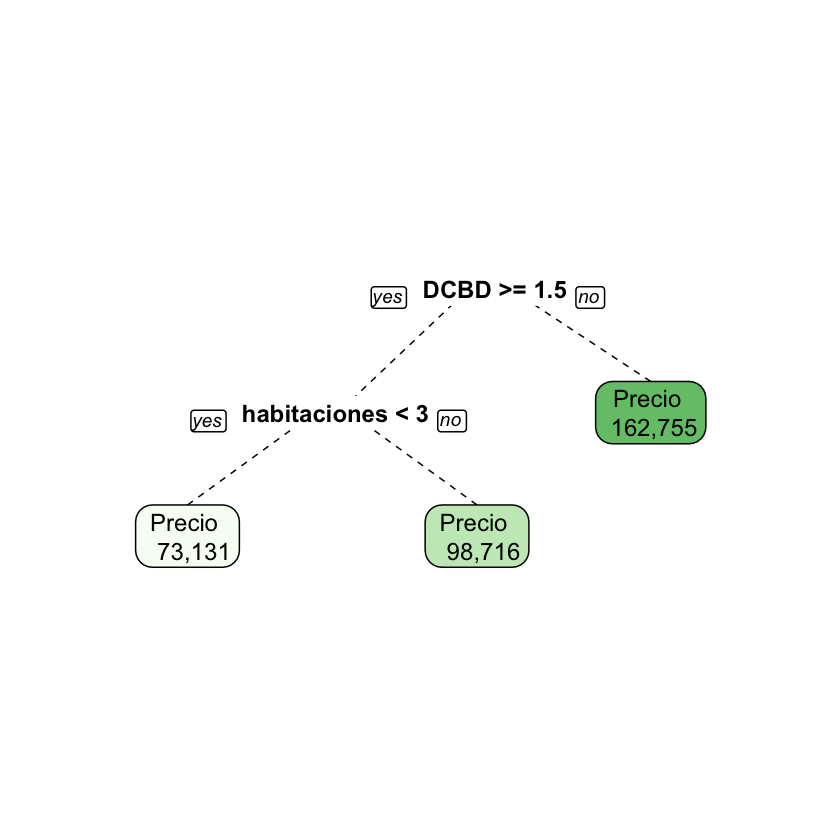

In [14]:
p_load("rpart.plot")

prp(mytree, under = TRUE, branch.lty = 2, yesno = 2, faclen = 0, varlen=15,tweak=1.2,clip.facs= TRUE,box.palette = "Greens",compress=TRUE,ycompress = TRUE,node.fun=function(x, labs, digits, varlen) paste("Precio \n", format(round(mytree$frame$yval, 0), nsmall=0, big.mark=",")))

In [15]:
mytree_full<-rpart(log(price)~DCBD+habitaciones,data=db,cp=-1)

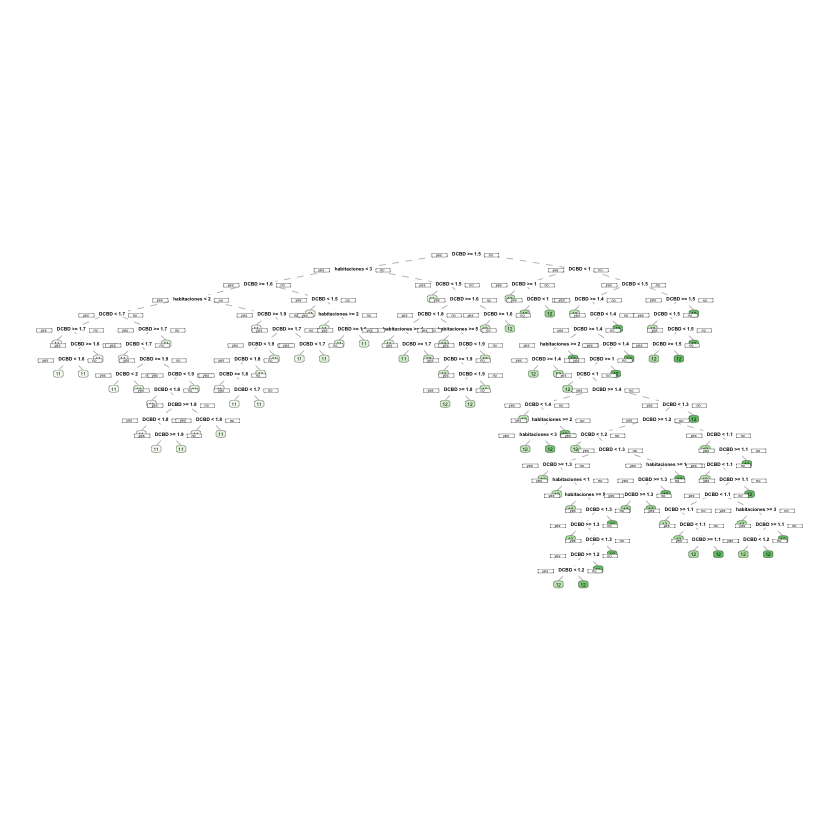

In [16]:
prp(mytree_full, under = TRUE, branch.lty = 2, yesno = 2, faclen = 0, varlen=15,tweak=1.2,clip.facs= TRUE,box.palette = "Greens",compress=TRUE,ycompress = TRUE)

##### With Ames Data Set

There are multiple packages, we are going to use `rpart`

In [17]:
p_load("rpart")

In [18]:
p_load("modeldata")

data("ames", package = "modeldata")

ames<-ames  %>% filter(Neighborhood %in%c("North_Ames", "College_Creek", "Old_Town", "Edwards", "Somerset", "Northridge_Heights", "Gilbert", "Sawyer", "Northwest_Ames", "Sawyer_West"))


In [19]:
head(ames)

MS_SubClass,MS_Zoning,Lot_Frontage,Lot_Area,Street,Alley,Lot_Shape,Land_Contour,Utilities,Lot_Config,⋯,Fence,Misc_Feature,Misc_Val,Mo_Sold,Year_Sold,Sale_Type,Sale_Condition,Sale_Price,Longitude,Latitude
<fct>,<fct>,<dbl>,<int>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,⋯,<fct>,<fct>,<int>,<int>,<int>,<fct>,<fct>,<int>,<dbl>,<dbl>
One_Story_1946_and_Newer_All_Styles,Residential_Low_Density,141,31770,Pave,No_Alley_Access,Slightly_Irregular,Lvl,AllPub,Corner,⋯,No_Fence,None,0,5,2010,WD,Normal,215000,-93.61975,42.05403
One_Story_1946_and_Newer_All_Styles,Residential_High_Density,80,11622,Pave,No_Alley_Access,Regular,Lvl,AllPub,Inside,⋯,Minimum_Privacy,None,0,6,2010,WD,Normal,105000,-93.61976,42.05301
One_Story_1946_and_Newer_All_Styles,Residential_Low_Density,81,14267,Pave,No_Alley_Access,Slightly_Irregular,Lvl,AllPub,Corner,⋯,No_Fence,Gar2,12500,6,2010,WD,Normal,172000,-93.61939,42.05266
One_Story_1946_and_Newer_All_Styles,Residential_Low_Density,93,11160,Pave,No_Alley_Access,Regular,Lvl,AllPub,Corner,⋯,No_Fence,None,0,4,2010,WD,Normal,244000,-93.61732,42.05125
Two_Story_1946_and_Newer,Residential_Low_Density,74,13830,Pave,No_Alley_Access,Slightly_Irregular,Lvl,AllPub,Inside,⋯,Minimum_Privacy,None,0,3,2010,WD,Normal,189900,-93.63893,42.06090
Two_Story_1946_and_Newer,Residential_Low_Density,78,9978,Pave,No_Alley_Access,Slightly_Irregular,Lvl,AllPub,Inside,⋯,No_Fence,None,0,6,2010,WD,Normal,195500,-93.63893,42.06078


The description of the variables can be viewed here: https://jse.amstat.org/v19n3/decock/DataDocumentation.txt

In [20]:
class(ames$Fence)

[1] "factor"

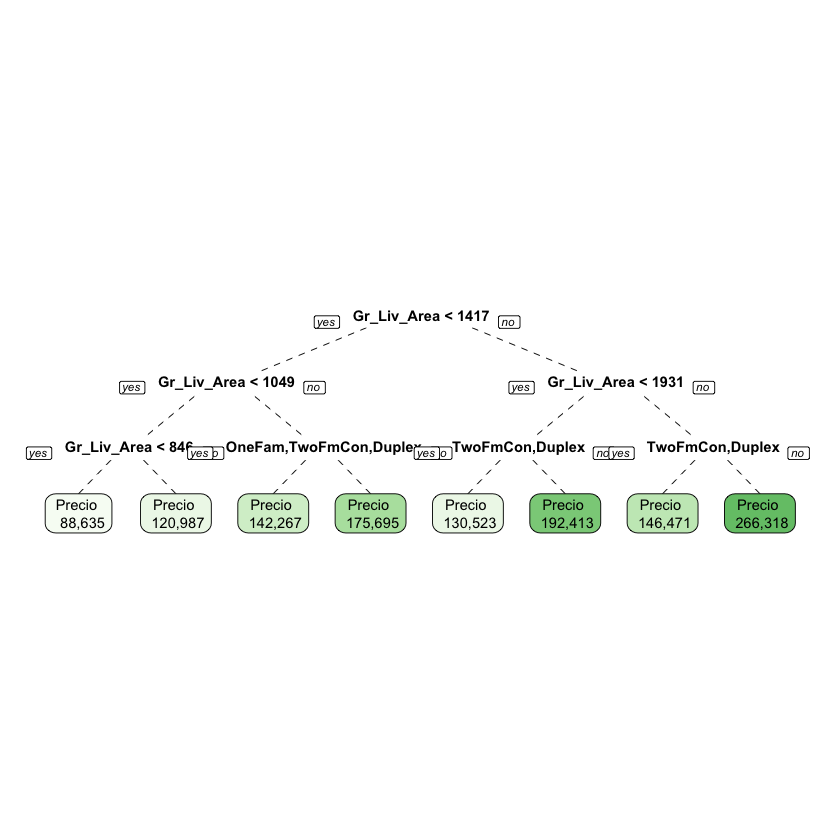

In [21]:
amestree<-rpart(log(Sale_Price) ~ Gr_Liv_Area  + Bldg_Type + Fence + Lot_Area,data=ames, control = list(maxdepth = 3))

p_load("rpart.plot")
prp(amestree, under = TRUE, branch.lty = 2, yesno = 2, faclen = 0, varlen=15,tweak=1.2,clip.facs= TRUE,box.palette = "Greens",compress=FALSE,ycompress = FALSE,node.fun=function(x, labs, digits, varlen) paste("Precio \n", format(round(exp(amestree$frame$yval), 0), nsmall=0, big.mark=",")))

### Sobreajuste

In [28]:
amestree<-rpart(log(Sale_Price) ~ Gr_Liv_Area  + Bldg_Type + Fence + Lot_Area,data=ames,cp=.1)

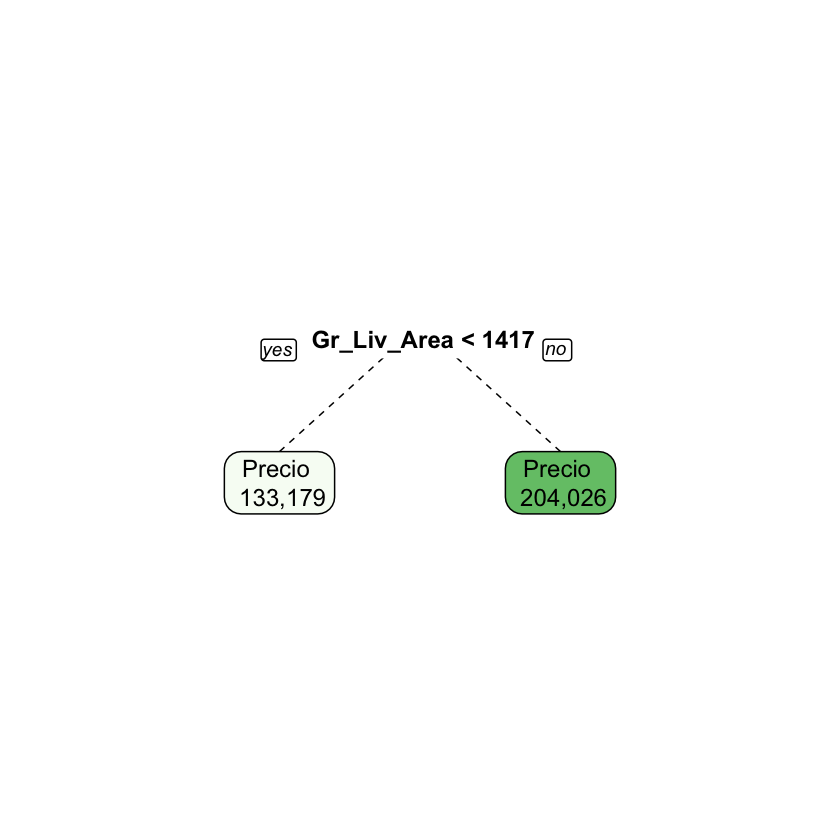

In [29]:
p_load("rpart.plot")
prp(amestree, under = TRUE, branch.lty = 2, yesno = 2, faclen = 0, varlen=15,tweak=1.2,clip.facs= TRUE,box.palette = "Greens",compress=FALSE,ycompress = FALSE,node.fun=function(x, labs, digits, varlen) paste("Precio \n", format(round(exp(amestree$frame$yval), 0), nsmall=0, big.mark=",")))


- Fijar la profundidad del árbol. (implementado en Caret `method=rpart2`)

- Fijar la mínima cantidad de datos que están contenidos dentro de cada hoja. 

- Cost complexity pruning (implementado en Caret con `method=rpart`)

`tidymodels` implementa todos

##### Implementación con Caret

In [30]:
p_load("caret")

In [31]:
fitControl<-trainControl(method ="cv",
                         number=5)

#####  `method=rpart2`  allows to tune Max Tree Depth

In [32]:
set.seed(123)
tree_rpart2 <- train(
    log(Sale_Price) ~ Gr_Liv_Area  + Bldg_Type + Fence + Lot_Area,
    data=ames,
    method = "rpart2",
    trControl = fitControl,
    tuneGrid = expand.grid(maxdepth = seq(1,30,1))
)

In [33]:
tree_rpart2

CART 

2063 samples
   4 predictor

No pre-processing
Resampling: Cross-Validated (5 fold) 
Summary of sample sizes: 1651, 1651, 1650, 1651, 1649 
Resampling results across tuning parameters:

  maxdepth  RMSE       Rsquared   MAE      
   1        0.3076130  0.3221351  0.2299792
   2        0.2920483  0.3896141  0.2152181
   3        0.2832392  0.4266327  0.2095505
   4        0.2790818  0.4431936  0.2081170
   5        0.2740480  0.4630493  0.2036835
   6        0.2697981  0.4801112  0.2008007
   7        0.2673430  0.4891130  0.1988199
   8        0.2670243  0.4906269  0.1984846
   9        0.2670880  0.4907169  0.1984789
  10        0.2670880  0.4907169  0.1984789
  11        0.2670880  0.4907169  0.1984789
  12        0.2670880  0.4907169  0.1984789
  13        0.2670880  0.4907169  0.1984789
  14        0.2670880  0.4907169  0.1984789
  15        0.2670880  0.4907169  0.1984789
  16        0.2670880  0.4907169  0.1984789
  17        0.2670880  0.4907169  0.1984789
  18        0.2

In [ ]:
prp(tree_rpart2$finalModel, under = TRUE, branch.lty = 2, yesno = 2, faclen = 0, varlen=15,tweak=1.2,clip.facs= TRUE,box.palette = "Greens",compress=FALSE,ycompress = FALSE,node.fun=function(x, labs, digits, varlen) paste("Precio \n", format(round(exp(tree_rpart2$finalModel$frame$yval), 0), nsmall=0, big.mark=",")))

##### Tidymodels

In [34]:
p_load("tidymodels")

# Model setting
tree_model_tune_params <- decision_tree(tree_depth = tune(),
                                        min_n      = tune()) %>% 
  set_engine("rpart") %>% 
  set_mode("regression") 



# Receipe
rec_1 <- recipe(Sale_Price ~  Gr_Liv_Area  + Bldg_Type  + Fence ,data=ames)  %>% 
         step_log(Sale_Price)


# Folds
set.seed(234)
ames_folds <- vfold_cv(ames,
              v       = 5
             )

In [36]:
14*99

[1] 1386

In [35]:
# workflow
tree_wf <- workflow() %>%
                     add_recipe(rec_1) %>%
                     add_model(tree_model_tune_params)

tree_grid <- grid_regular( # Rango de búsqueda para cada hiperparámetro
                  tree_depth(range = c(1, 15), trans = NULL),
                  min_n(range = c(2, 100), trans = NULL),
                 levels=c(14,99))  

tree_grid


tree_depth,min_n
<int>,<int>
1,2
2,2
3,2
4,2
5,2
6,2
7,2
8,2
9,2


In [ ]:
dim(tree_grid)

<div >
<img src = "figures/gridsearch.png" />
</div>

In [37]:
tree_grid_Random <- grid_random( # Rango de búsqueda para cada hiperparámetro
                  tree_depth(range = c(1, 15), trans = NULL),
                  min_n(range = c(2, 100), trans = NULL),
                  # Número valores por hiperparámetro
                  size = 25) 

tree_grid_Random

tree_depth,min_n
<int>,<int>
5,21
13,65
1,10
9,18
3,69
14,17
14,16
6,74
6,65


In [38]:
#train

tree_res <- 
  tree_wf %>% 
  tune_grid(
    resamples = ames_folds,
    grid = tree_grid_Random,
    metrics= metric_set( mae)      
    )



In [ ]:
tree_res %>% 
  collect_metrics(summarize = TRUE)

In [ ]:
best_tree <- tree_res %>% select_best(metric="mae")

In [ ]:
final_wf <- 
  tree_wf %>% 
  finalize_workflow(best_tree)

final_wf

#### Cost complexity Prunning


Cost complexity del árbol  $T$ con $[T]$ nodos terminales del árbol 
\begin{align}
  C_{\alpha}(T)= \sum_{m=1}^{[T]}  \sum_{x_i\in R_m} (y_i-\hat{y}_m)^2 + \alpha [T]
\end{align}


Objetivo: para un dado $\alpha$, encontrar el pruning óptimo que minimice  $C_{\alpha}(T)$

Se logra eliminando sucesivamente las ramas que producen un aumento mínimo en $\sum_{x_i\in R_m} (y_i-\hat{y}_m)^2 $


##### Algoritmo completo

  - Hacemos crecer el árbol

  - Para un dado $\alpha$, aplicamos  *cost complexity pruning* 
    
  - Utilizamos K-fold cross-validation para elegir $\alpha$. 

  
Tenemos entonces una secuencia de subarboles para distintos valores de $\alpha$ 

Elegimos el $\alpha$ y el subárbol que tienen el menor error de predicción.

#####  `method=rpart`  only allows to tune Complexity Parameter

- Can change the length


In [39]:
set.seed(123)
tree_lenght <- train(
    log(Sale_Price) ~ Gr_Liv_Area  + Bldg_Type + Fence + Lot_Area,
    data=ames,
    method = "rpart",
    metric="MAE",
    trControl = fitControl,
    tuneLength=100
)

Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”


In [40]:
tree_lenght

CART 

2063 samples
   4 predictor

No pre-processing
Resampling: Cross-Validated (5 fold) 
Summary of sample sizes: 1651, 1651, 1650, 1651, 1649 
Resampling results across tuning parameters:

  cp            RMSE       Rsquared   MAE      
  0.0001829893  0.2597482  0.5279496  0.1901113
  0.0001835106  0.2597482  0.5279496  0.1901113
  0.0002043565  0.2598933  0.5273574  0.1901204
  0.0002129807  0.2599535  0.5271216  0.1900896
  0.0002147647  0.2599535  0.5271216  0.1900896
  0.0002179573  0.2598733  0.5274092  0.1899765
  0.0002586037  0.2596582  0.5279250  0.1899910
  0.0002918794  0.2595264  0.5284919  0.1900346
  0.0003021826  0.2594587  0.5287884  0.1899449
  0.0003100108  0.2594441  0.5288437  0.1898085
  0.0003117163  0.2595105  0.5286103  0.1898569
  0.0003127046  0.2595105  0.5286103  0.1898569
  0.0003135710  0.2594809  0.5287295  0.1897946
  0.0003176683  0.2594048  0.5289767  0.1896716
  0.0003177627  0.2594048  0.5289767  0.1896716
  0.0003249438  0.2593189  0.5292462  0

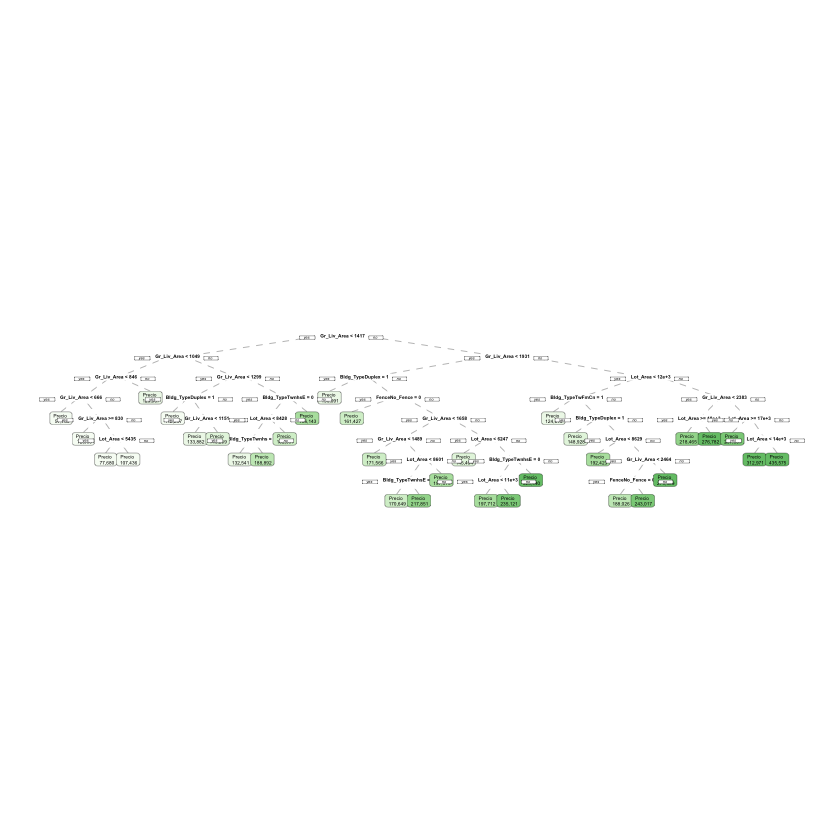

In [41]:
prp(tree_lenght$finalModel, under = TRUE, branch.lty = 2, yesno = 2, faclen = 0, varlen=15,tweak=1.2,clip.facs= TRUE,box.palette = "Greens",compress=FALSE,ycompress = FALSE,node.fun=function(x, labs, digits, varlen) paste("Precio \n", format(round(exp(tree_lenght$finalModel$frame$yval), 0), nsmall=0, big.mark=",")))

- Or the grid

In [ ]:
set.seed(123)
tree_grid <- train(
    log(Sale_Price) ~ Gr_Liv_Area  + Bldg_Type + Fence + Lot_Area,
    data=ames,
    method = "rpart",
    trControl = fitControl,
    tuneGrid = expand.grid(cp = seq(0.001707763, 0.001707765, length.out = 100))
)


In [ ]:
tree_grid

More details here: https://topepo.github.io/caret/train-models-by-tag.html#tree-based-model

##### Tidymodels

In [ ]:
# Model setting
tree_model_tune_complex <- decision_tree(cost_complexity = tune()) %>% #Change here
  set_engine("rpart") %>% 
  set_mode("regression") 

# As before

tree_wf <- workflow() %>%
                     add_recipe(rec_1) %>%
                     add_model(tree_model_tune_complex)

tree_grid_complexity <- grid_regular(cost_complexity(),
                          levels = 5) #at least 100

#train
best_tree <- 
  tree_wf %>% 
  tune_grid(
    resamples = ames_folds,
    grid = tree_grid_complexity,
    metrics= metric_set( mae)      
    ) %>%
  select_best("mae")


#End workflow
tree_wf %>% 
  finalize_workflow(best_tree)


### Comentarios sobre Árboles


#### Pros: 
  
    - Los árboles son muy fáciles de explicar a las personas (probablemente incluso más fáciles que la regresión lineal)

    - Los árboles se pueden trazar gráficamente y son fácilmente interpretados incluso por no expertos. Variables más importantes en la parte superior



#### Cons:
    
    - Si la estructura es lineal, CART no funciona bien
    
<div >
<img src = "figures/tree_vs_reg.png" />
</div>


    - Los árboles no son muy robustos 
    

In [42]:
set.seed(123)
tree_rpart2_rob <- train(
    log(Sale_Price) ~ Gr_Liv_Area  + Bldg_Type + Fence + Lot_Area,
    data=ames[-c(1:20),],
    method = "rpart2",
    trControl = fitControl,
    tuneGrid = expand.grid(maxdepth = seq(1,30,1))
)

In [43]:
tree_rpart2_rob

CART 

2043 samples
   4 predictor

No pre-processing
Resampling: Cross-Validated (5 fold) 
Summary of sample sizes: 1634, 1636, 1633, 1635, 1634 
Resampling results across tuning parameters:

  maxdepth  RMSE       Rsquared   MAE      
   1        0.3093770  0.3188655  0.2317362
   2        0.2936029  0.3872337  0.2172230
   3        0.2836288  0.4292888  0.2100289
   4        0.2804283  0.4416750  0.2071989
   5        0.2754844  0.4617727  0.2049167
   6        0.2720396  0.4746310  0.2022798
   7        0.2703747  0.4814416  0.2004039
   8        0.2685697  0.4885841  0.1984887
   9        0.2684559  0.4889455  0.1982535
  10        0.2684559  0.4889455  0.1982535
  11        0.2684559  0.4889455  0.1982535
  12        0.2684559  0.4889455  0.1982535
  13        0.2684559  0.4889455  0.1982535
  14        0.2684559  0.4889455  0.1982535
  15        0.2684559  0.4889455  0.1982535
  16        0.2684559  0.4889455  0.1982535
  17        0.2684559  0.4889455  0.1982535
  18        0.2

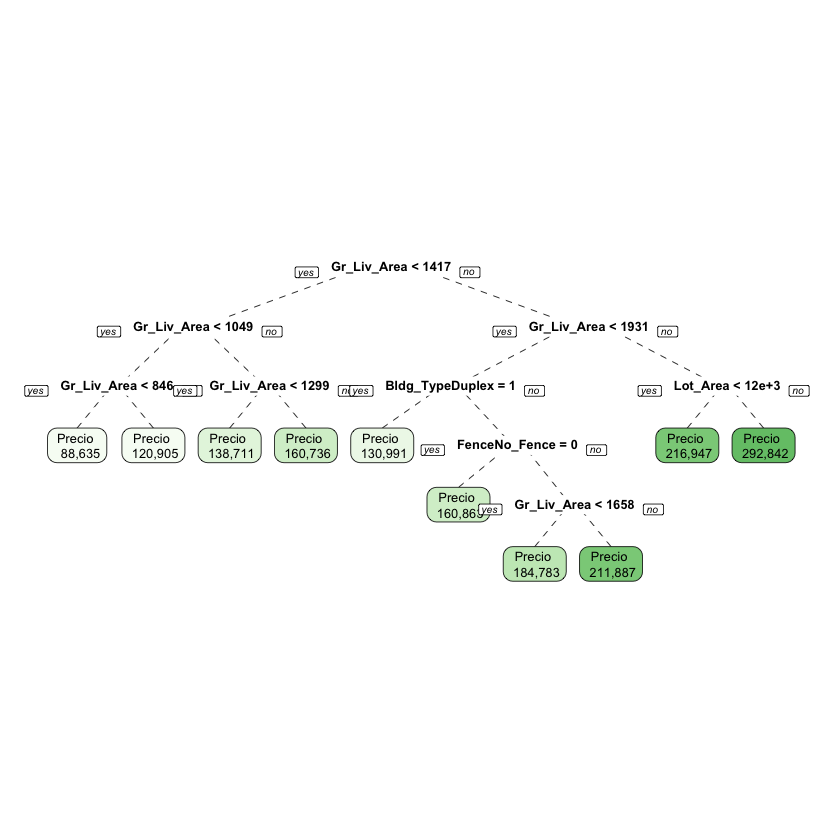

In [44]:
prp(tree_rpart2_rob$finalModel, under = TRUE, branch.lty = 2, yesno = 2, faclen = 0, varlen=15,tweak=1.2,clip.facs= TRUE,box.palette = "Greens",compress=FALSE,ycompress = FALSE,node.fun=function(x, labs, digits, varlen) paste("Precio \n", format(round(exp(tree_rpart2_rob$finalModel$frame$yval), 0), nsmall=0, big.mark=",")))

#### Change the sample

In [46]:
db_sample<- sample_frac(ames,size=1,replace=TRUE) #takes a sample with replacement of the same size of the original sample (1 or 100%)

In [47]:
set.seed(123)
tree_rpart2_rob_sample <- train(
    log(Sale_Price) ~ Gr_Liv_Area  + Bldg_Type + Fence + Lot_Area,
    data=db_sample,
    method = "rpart2",
    trControl = fitControl,
    tuneGrid = expand.grid(maxdepth = seq(1,30,1))
)

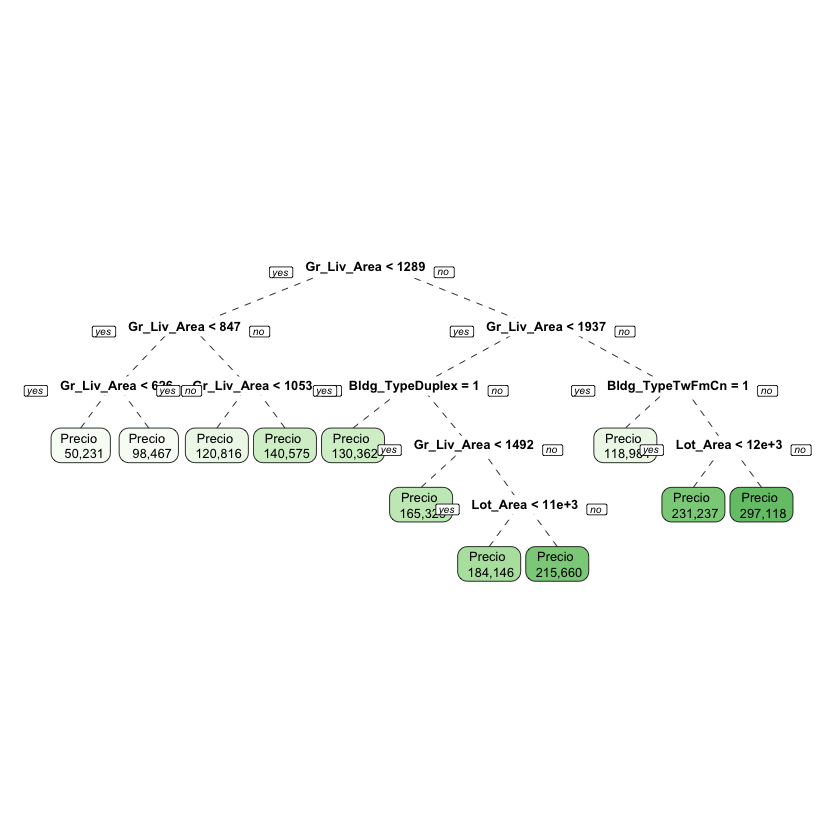

In [48]:
prp(tree_rpart2_rob_sample$finalModel, under = TRUE, branch.lty = 2, yesno = 2, faclen = 0, varlen=15,tweak=1.2,clip.facs= TRUE,box.palette = "Greens",compress=FALSE,ycompress = FALSE,node.fun=function(x, labs, digits, varlen) paste("Precio \n", format(round(exp(tree_rpart2_rob_sample$finalModel$frame$yval), 0), nsmall=0, big.mark=",")))

## Random Forests

We are going to use `ranger: A Fast Implementation of Random Forests`

In [49]:
p_load("ranger")

In [50]:
set.seed(123)

tree_ranger <- train(
    log(Sale_Price) ~ Gr_Liv_Area  + Bldg_Type + Fence,
    data=ames,
    method = "ranger",
    trControl = fitControl,
    tuneGrid=expand.grid(
              mtry = 1,
              splitrule = "variance",
              min.node.size = 5)
)

In [51]:
tree_ranger

Random Forest 

2063 samples
   3 predictor

No pre-processing
Resampling: Cross-Validated (5 fold) 
Summary of sample sizes: 1651, 1651, 1650, 1651, 1649 
Resampling results:

  RMSE       Rsquared   MAE      
  0.3177917  0.4601896  0.2323413

Tuning parameter 'mtry' was held constant at a value of 1
Tuning
 parameter 'splitrule' was held constant at a value of variance

Tuning parameter 'min.node.size' was held constant at a value of 5

Tuning parameters:

    - mtry (#Randomly Selected Predictors)
    - splitrule (Splitting Rule)
    - min.node.size (Minimal Node Size)



In [52]:
set.seed(123)

tree_ranger_grid <- train(
    log(Sale_Price) ~ Gr_Liv_Area  + Bldg_Type + Fence,
    data=ames,
    method = "ranger",
    trControl = fitControl,
    tuneGrid=expand.grid(
              mtry = c(1,2,3),
              splitrule = "variance",
              min.node.size = c(5,10,15)),
              importance = 'permutation'
)

In [53]:
tree_ranger_grid

Random Forest 

2063 samples
   3 predictor

No pre-processing
Resampling: Cross-Validated (5 fold) 
Summary of sample sizes: 1651, 1651, 1650, 1651, 1649 
Resampling results across tuning parameters:

  mtry  min.node.size  RMSE       Rsquared   MAE      
  1      5             0.3169043  0.4633973  0.2316323
  1     10             0.3187282  0.4558531  0.2332558
  1     15             0.3192152  0.4574563  0.2337218
  2      5             0.2718699  0.5459319  0.1948974
  2     10             0.2716431  0.5461592  0.1949878
  2     15             0.2723888  0.5450137  0.1953341
  3      5             0.2494286  0.5782360  0.1786118
  3     10             0.2495220  0.5776118  0.1787281
  3     15             0.2493990  0.5779976  0.1786248

Tuning parameter 'splitrule' was held constant at a value of variance
RMSE was used to select the optimal model using the smallest value.
The final values used for the model were mtry = 3, splitrule = variance
 and min.node.size = 15.

# Variable Importance

In [54]:
rangerImp <- varImp(tree_ranger_grid, scale = TRUE)
rangerImp

ranger variable importance

                        Overall
Gr_Liv_Area            100.0000
Bldg_TypeDuplex          7.4977
Bldg_TypeTwoFmCon        4.4961
FenceNo_Fence            3.6890
Bldg_TypeTwnhsE          2.2665
FenceMinimum_Privacy     2.0339
FenceGood_Wood           1.0399
Bldg_TypeTwnhs           0.4904
FenceMinimum_Wood_Wire   0.0000